In [127]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing

import matplotlib.pyplot as plt
plt.style.use("ggplot")

%matplotlib inline

In [128]:
# equivalent of 4 months
DAYS = 120
# make bin/step size equal to 1/24, 1hr
BIN_WIDTH = 1 / 24
UNITS = int(DAYS / BIN_WIDTH)
# keeping difference large so the sine won't be too smooth
time = np.arange(0, DAYS, BIN_WIDTH);

In [129]:
# periodic series
signal = np.sin(time)
# add some noise
small_noise = np.random.normal(-0.25, 0.25, UNITS)
noised_signal = small_noise + signal

In [130]:
# add some spikes
SPIKE_SCALING_FACTOR = 5
RANDS = int(0.05 * UNITS)
SPIKE_NOISE = np.random.normal(0, 1, RANDS)
RANDOM_SPIKES = np.random.choice(UNITS, RANDS)
spike_factors = np.ones_like(signal)
spike_factors[RANDOM_SPIKES] = spike_factors[RANDOM_SPIKES] * (SPIKE_SCALING_FACTOR + SPIKE_NOISE)
noised_with_spikes = signal * spike_factors

In [131]:
def smooth(signal, window_size, window_fn):
    """ generic smoothing function that using window size & window function"""
    # suppress divide by 0 and invalid subtraction errors
    ext = np.r_[2 * signal[0] - signal[window_size - 1::-1],
                signal,
                2 * signal[-1] - signal[-1:-window_size:-1]]
    weights = window_fn(window_size)
    smoothed = np.convolve(weights / weights.sum(), ext, mode='same')
    return smoothed[window_size:-window_size + 1]

In [132]:
def compute_loss(smooth_type, smooth_fn=np.hamming, smooth_size=7, sigma=SIGMA):
    smoothed = smooth(noised_with_spikes, window_fn=smooth_fn, window_size=smooth_size)    
    df = pd.DataFrame({
        'smooth': smoothed,
        'actual': noised_with_spikes,
        'residual': smoothed - noised_with_spikes
    })
    # z-score
    df['z'] = stats.zscore(df.residual)
    outliers = df.loc[df.z.abs() >= sigma]
    missed = set(RANDOM_SPIKES) - set(outliers.index.values)
    wrong = set(outliers.index.values) - set(RANDOM_SPIKES)
    return missed, wrong, len(outliers), df

In [133]:
smooth_dict = {
    'hamming': np.hamming
}
# 3 hours to 21 hours
SIZES = np.arange(3, 21, 2)
SIGMAS = list(range(2, 5))
records = []
dfs = {}
for smooth_type, fn in smooth_dict.items():
    for size in SIZES:
        for sigma in SIGMAS:
            missed, wrong, total, data = compute_loss(smooth_type, fn, size, sigma)
            dfs[(smooth_type, size, sigma)] = data
            records.append({
                "wrong": len(wrong),
                "missed": len(missed),
                "predicted": total,
                "actual": len(RANDOM_SPIKES),
                "sigma": sigma,
                "size": size,
                "smooth_type": smooth_type
            })
results = pd.DataFrame(records)

In [134]:
results['wrong_pct'] = results.wrong / results.predicted
results['missed_pct'] = results.missed / results.actual

In [135]:
# trying to minimize the number of wrong guesses
# because we would rather air on the side of caution
# threshold may need to rise for different data set
THRESHOLD = 0.05
good_enough = results.loc[results.wrong_pct <= THRESHOLD].sort_values('size')
print(f'Minimum smoothing window size, sigma given threshold ({THRESHOLD}): {good_enough[["size", "sigma"]].min().values}')

Minimum smoothing window size, sigma given threshold (0.05): [3 2]


In [136]:
keys = good_enough[['smooth_type', 'size', 'sigma']].to_records(index=False).tolist()

In [137]:
def compute_stats(config):
    df = dfs[config]
    outliers = df.loc[df.z.abs() >= config[2]]
    predicted = set(outliers.index.values)
    # allow to predict slightly early or late
    preds = np.array(list(predicted))
    close_enough = predicted.union(set(list(preds + 1))).union(set(list(preds - 1)))
    actual = set(RANDOM_SPIKES)
    missed = actual.difference(close_enough)
    correct = actual.intersection(close_enough)
    wrong = predicted.difference(actual)
    return correct, wrong, missed

def plot_data(data):
    # x lower bound to pin error bars to x axis
    # padding of 2
    fig = plt.figure(dpi=200, figsize=(20,10))
    ax = plt.gca()
    # simulate real date range
    fake_date_range = pd.date_range('2018-01-01', freq='1H', periods=UNITS)
    data = data.set_index(fake_date_range)
    data.plot(ax=ax, alpha=0.5)
    ymin = data.min().min()
    xlb = ymin + np.abs(ymin) // 2
    plt.vlines([fake_date_range[i].to_pydatetime() for i in correct], xlb, xlb + 0.5, color='green', label='correct')
    plt.vlines([fake_date_range[i].to_pydatetime() for i in wrong], xlb, xlb + 0.5, color='red', label='incorrect')
    plt.vlines([fake_date_range[i].to_pydatetime() for i in missed], xlb, xlb + 0.5, color='black', linestyles='dotted', label='missed')
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(' - '.join(list(map(str, best_config))), fontdict={'color': 'black'})

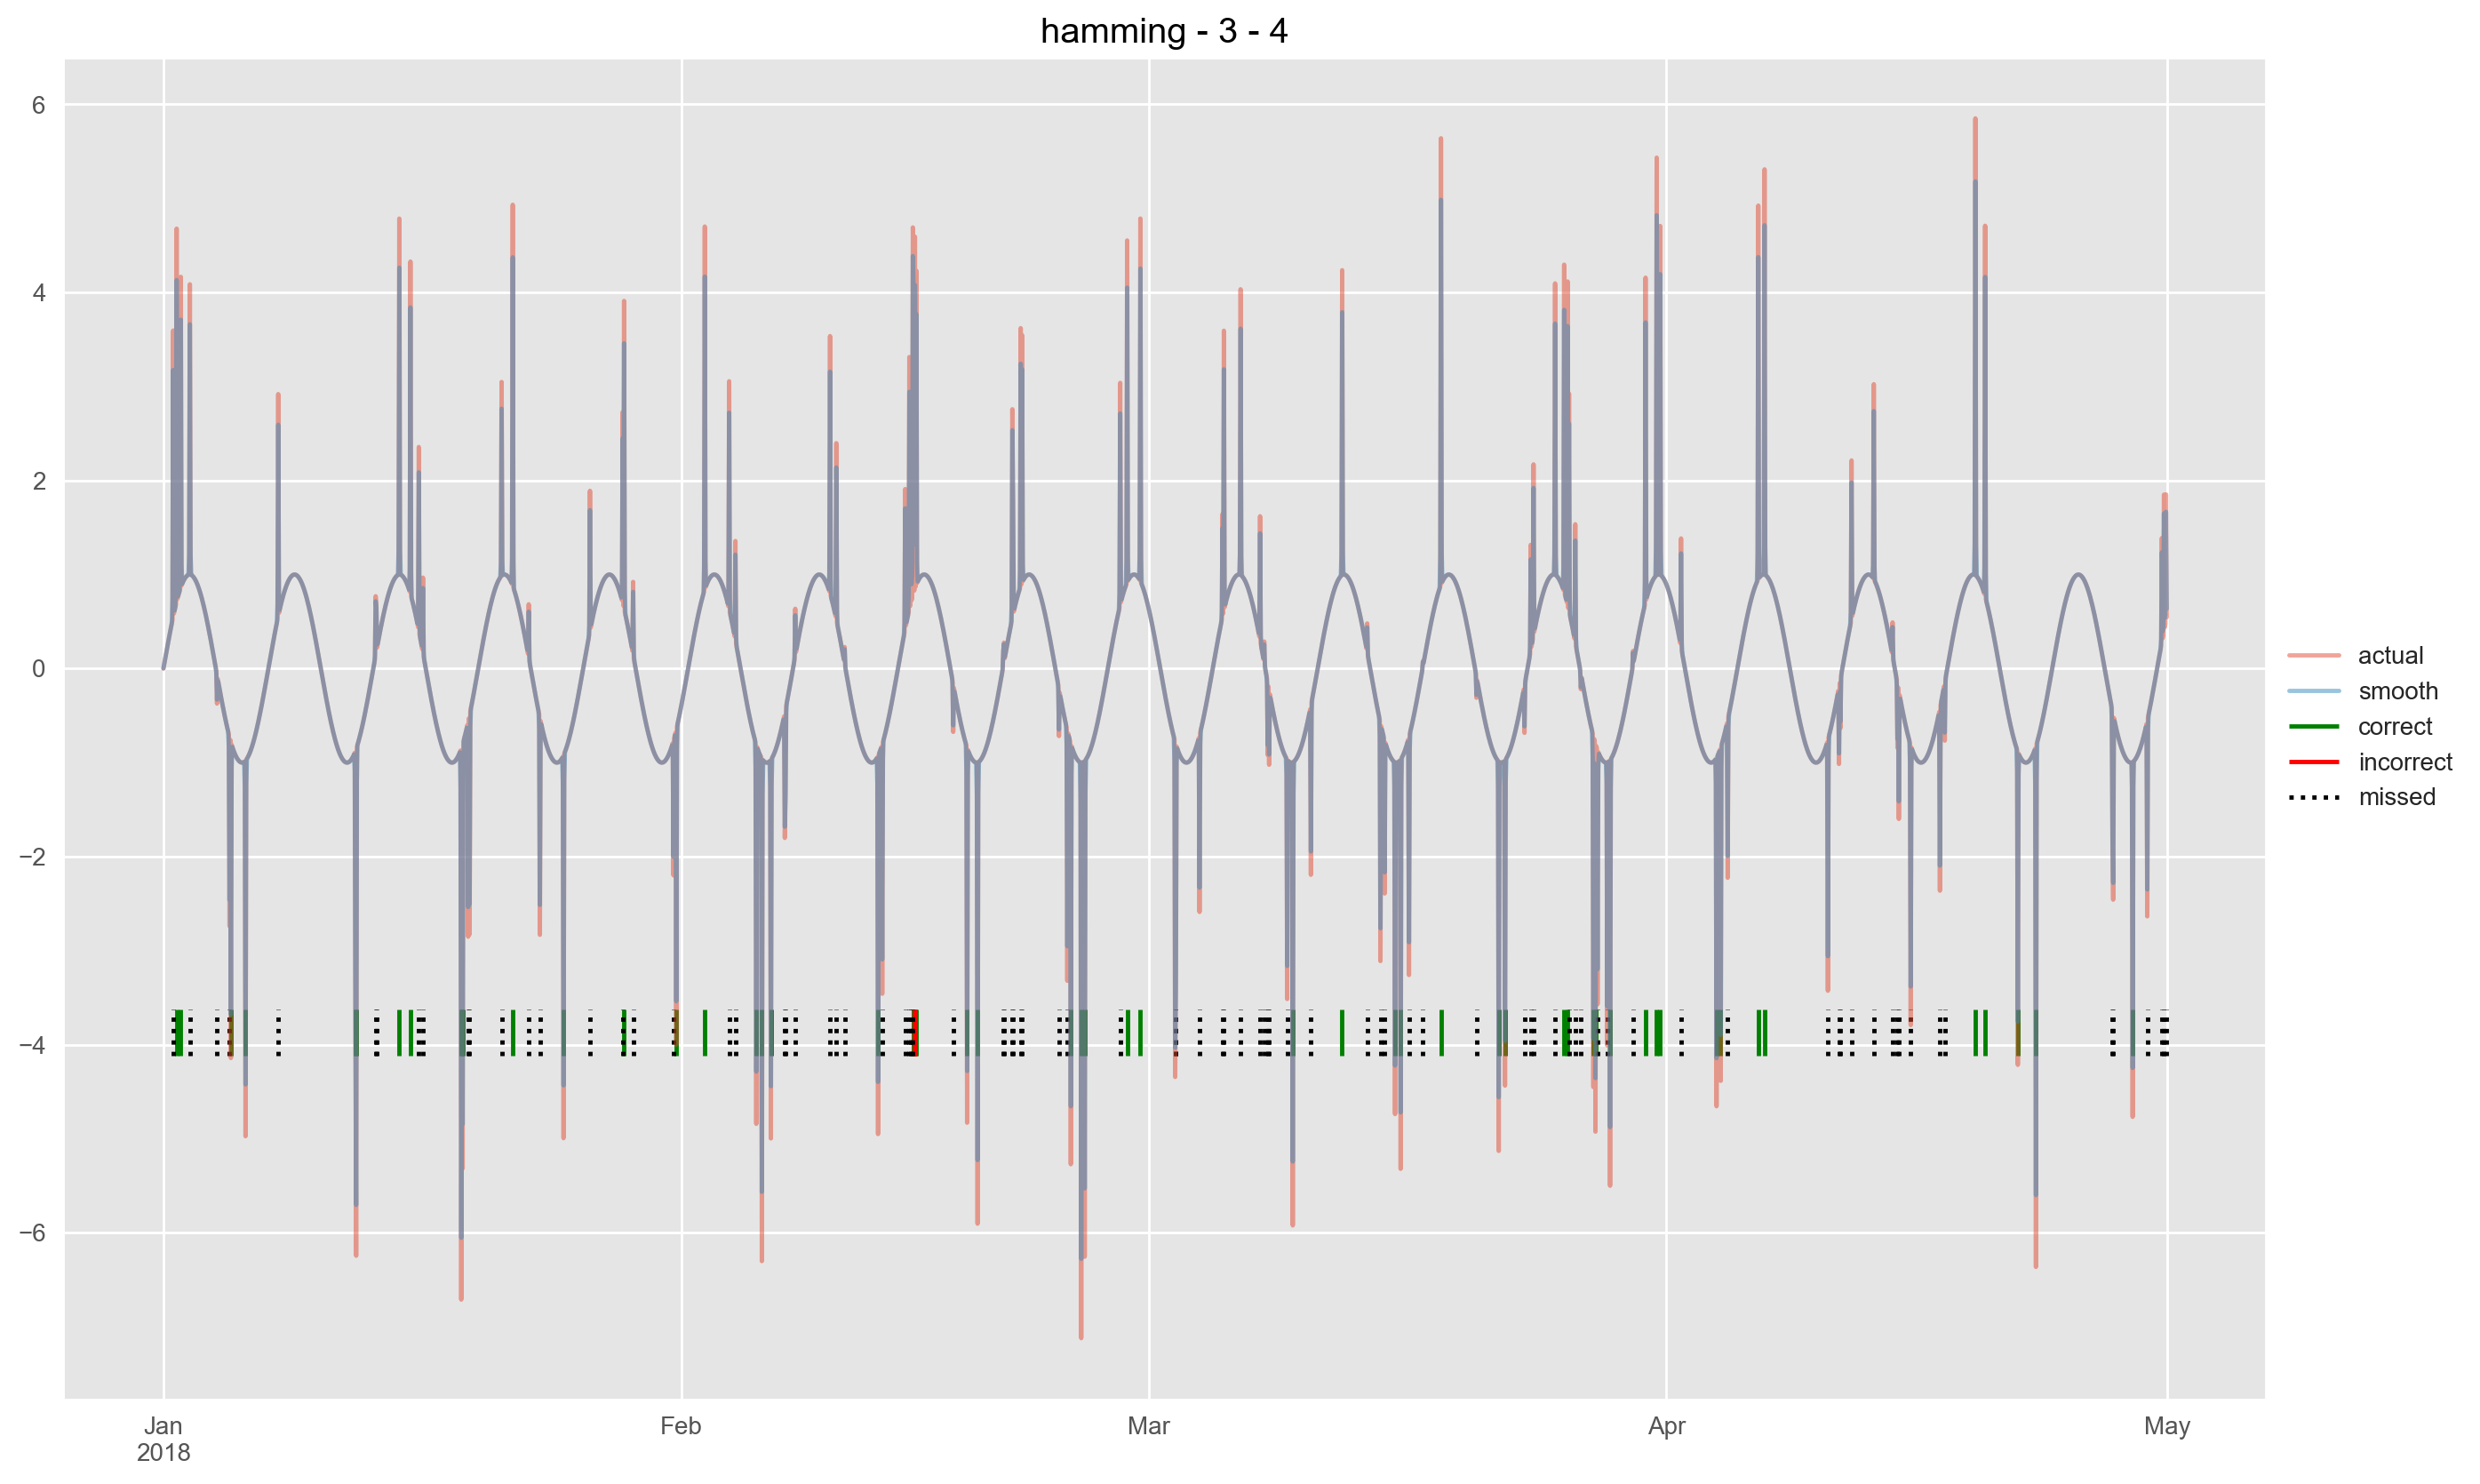

In [153]:
best_config = keys[0]
correct, wrong, missed = compute_stats(best_config)
plot_data(dfs[best_config][['actual', 'smooth']])

In [154]:
len(correct)

54

In [155]:
len(wrong)

2